#Multi-Criteria Risk Based Bug Severity Classifiaction

## Installing Libraries

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing dataset

In [ ]:
df = pd.read_csv('bugs.csv')
df.head()

,Bug ID,Product,Component,Assignee,Status,Resolution,Summary,Changed,Depends on,Keywords,Priority,Severity,Classification
0,570408,4DIAC,4DIAC-IDE,4diac-inbox,UNCONFIRMED,---,Error after dragging a FB from system explorer...,2021-01-16 04:45:59,NaN,NaN,P3,normal,IoT
1,570579,4DIAC,4DIAC-IDE,4diac-inbox,UNCONFIRMED,---,Properties sheet for VirtualIO element,2021-01-22 11:52:53,NaN,NaN,P3,normal,IoT
2,571157,4DIAC,FORTE,4diac-inbox,UNCONFIRMED,---,SegFault may appear on Modbus Poll while termi...,2021-03-24 06:32:42,NaN,NaN,P3,critical,IoT
3,572153,4DIAC,4DIAC-IDE,4diac-inbox,UNCONFIRMED,---,ECC states with the same name,2021-03-22 03:40:38,NaN,NaN,P3,normal,IoT
4,572264,4DIAC,FORTE,4diac-inbox,UNCONFIRMED,---,Fdselecthandler has race condition in case of ...,2021-03-25 06:23:23,NaN,NaN,P3,normal,IoT


In [ ]:
df.shape

(7877, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7877 entries, 0 to 7876
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Bug ID          7877 non-null   int64 
 1   Product         7877 non-null   object
 2   Component       7877 non-null   object
 3   Assignee        7877 non-null   object
 4   Status          7877 non-null   object
 5   Resolution      7877 non-null   object
 6   Summary         7877 non-null   object
 7   Changed         7877 non-null   object
 8   Depends on      464 non-null    object
 9   Keywords        556 non-null    object
 10  Priority        7877 non-null   object
 11  Severity        7877 non-null   object
 12  Classification  7877 non-null   object
dtypes: int64(1), object(12)
memory usage: 800.1+ KB


## Checking for Null Values



In [ ]:
null_counts = df.isnull().sum()
print(null_counts)

Bug ID               0
Product              0
Component            0
Assignee             0
Status               0
Resolution           0
Summary              0
Changed              0
Depends on        7413
Keywords          7321
Priority             0
Severity             0
Classification       0
dtype: int64


<Axes: >

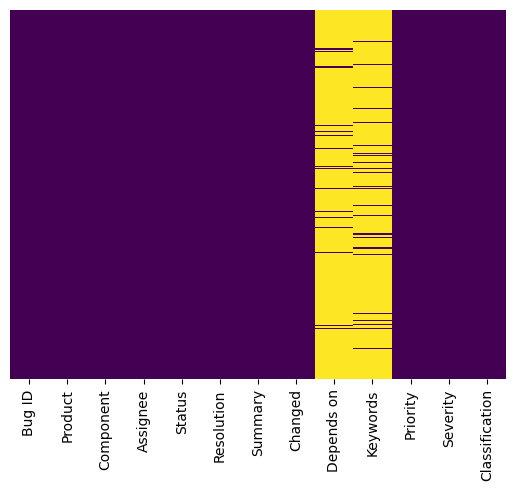

In [ ]:
import seaborn as sns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Data Cleaning


In [ ]:
df = df.drop(['Depends on'], axis = 1)
df = df.drop(['Keywords'], axis = 1)


<Axes: >

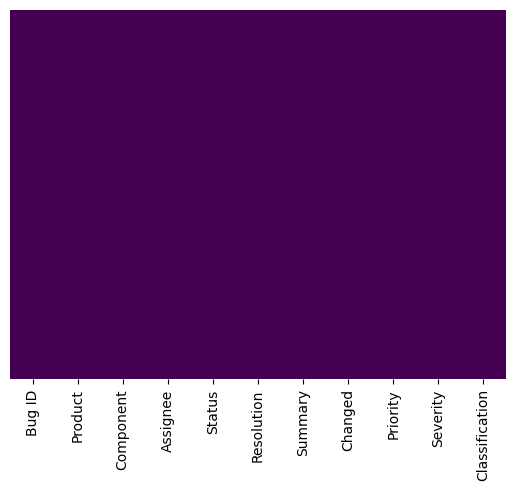

In [ ]:
import seaborn as sns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Missing Value Treatment and Encoding

In [ ]:
df = df.dropna(subset=['Severity'])

In [ ]:
df['Severity'].unique()


array(['normal', 'major', 'enhancement', 'blocker', 'minor', 'trivial',
       'critical'], dtype=object)

In [ ]:
df['Priority'].unique()

array(['P3', 'P4', 'P1', 'P2', 'P5'], dtype=object)

In [ ]:
priority_mapping = {'P1': 1, 'P2': 2, 'P3': 3, 'P4': 4, 'P5': 5}
severity_mapping = {'critical': 5, 'blocker': 4, 'major': 3, 'normal': 2, 'minor': 1, 'S1': 5,  'S2': 4, 'S3': 3, 'S4': 2, 'S5':1}

df['Severity'] = df['Severity'].map(severity_mapping).fillna(0)
df['Priority'] = df['Priority'].map(priority_mapping).fillna(0)

In [ ]:
df = df[df['Severity'] != 0]

In [ ]:
df['Severity'].unique()

array([2., 3., 4., 1., 5.])

In [ ]:
df = df[df['Priority'] != 0]

In [ ]:
df['Priority'].unique()

array([3, 4, 1, 2, 5])

In [ ]:
df['Component'].unique()
len(df['Component'].unique())

144

In [ ]:
unique_components = df['Component'].unique()

# Create a dictionary to map unique values to integer values
component_mapping = {component: idx + 1 for idx, component in enumerate(unique_components)}

# Map values in the 'Component' column to integer values
df['Component'] = df['Component'].map(component_mapping)
df['Component'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144])

## Feature Extraction


In [ ]:
df['Risk'] = df['Severity'] * df['Priority']
df['Risk']

0       6.0
1       6.0
2       9.0
3       6.0
4       6.0
       ... 
732     6.0
733     9.0
734     9.0
735     8.0
737    10.0
Name: Risk, Length: 645, dtype: float64

In [ ]:
# Calculate the frequency of bugs in each risk class
bug_frequency = df['Risk'].value_counts().sort_index()

# Print the frequency of bugs in each risk class
print("Frequency of Bugs in Each Risk Class:")
print(bug_frequency)


Frequency of Bugs in Each Risk Class:
Risk
3.0      11
4.0       3
6.0     536
8.0       7
9.0      54
10.0      1
12.0     15
15.0     18
Name: count, dtype: int64


## Choosing the value of K

In [ ]:
# Count the occurrences of each unique risk value
bugs_count_by_risk = df['Risk'].value_counts()

# Print the count of bugs for each risk
for risk, bugs_count in bugs_count_by_risk.items():
    print("Risk {}: {} bugs".format(risk, bugs_count))

Risk 6.0: 536 bugs
Risk 4.0: 312 bugs
Risk 3.0: 286 bugs
Risk 10.0: 286 bugs
Risk 12.0: 240 bugs
Risk 9.0: 54 bugs
Risk 15.0: 18 bugs
Risk 8.0: 7 bugs


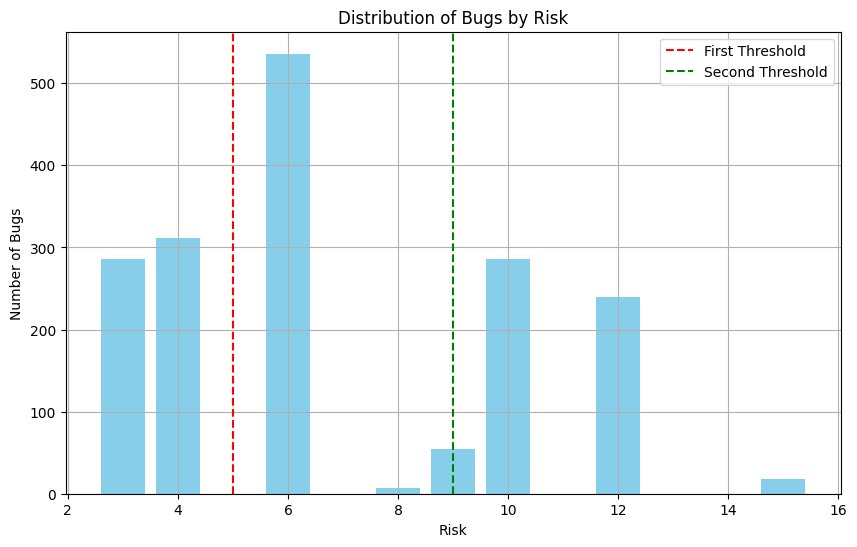

First Threshold: 5.0
Second Threshold: 9.0
Total Bugs in Low Region: 598
Total Bugs in Medium Region: 597
Total Bugs in High Region: 544


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming bugs_count_by_risk is a Series containing the frequency of bugs for each risk value
# If not, please replace it with the correct Series containing the bug frequencies
bugs_count_by_risk = df['Risk'].value_counts()

# Calculate total bugs
total_bugs = bugs_count_by_risk.sum()

# Calculate bugs per category
bugs_per_category = total_bugs / 3

# Calculate cumulative bugs for each risk class
cumulative_bugs = bugs_count_by_risk.sort_index().cumsum()

# Find first and second thresholds
first_threshold = cumulative_bugs[cumulative_bugs <= bugs_per_category].index[-1]
second_threshold = cumulative_bugs[cumulative_bugs <= 2 * bugs_per_category].index[-1]

# Count bugs in each region
low_region_bugs = bugs_count_by_risk[bugs_count_by_risk.index <= first_threshold].sum()
medium_region_bugs = bugs_count_by_risk[(bugs_count_by_risk.index > first_threshold) & (bugs_count_by_risk.index <= second_threshold)].sum()
high_region_bugs = bugs_count_by_risk[bugs_count_by_risk.index > second_threshold].sum()

# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.bar(bugs_count_by_risk.index, bugs_count_by_risk.values, color='skyblue')
plt.axvline(x=first_threshold, color='r', linestyle='--', label='First Threshold')
plt.axvline(x=second_threshold, color='g', linestyle='--', label='Second Threshold')
plt.xlabel('Risk')
plt.ylabel('Number of Bugs')
plt.title('Distribution of Bugs by Risk')
plt.legend()
plt.grid(True)
plt.show()

print("First Threshold:", first_threshold)
print("Second Threshold:", second_threshold)
print("Total Bugs in Low Region:", low_region_bugs)
print("Total Bugs in Medium Region:", medium_region_bugs)
print("Total Bugs in High Region:", high_region_bugs)


### Elbow method


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

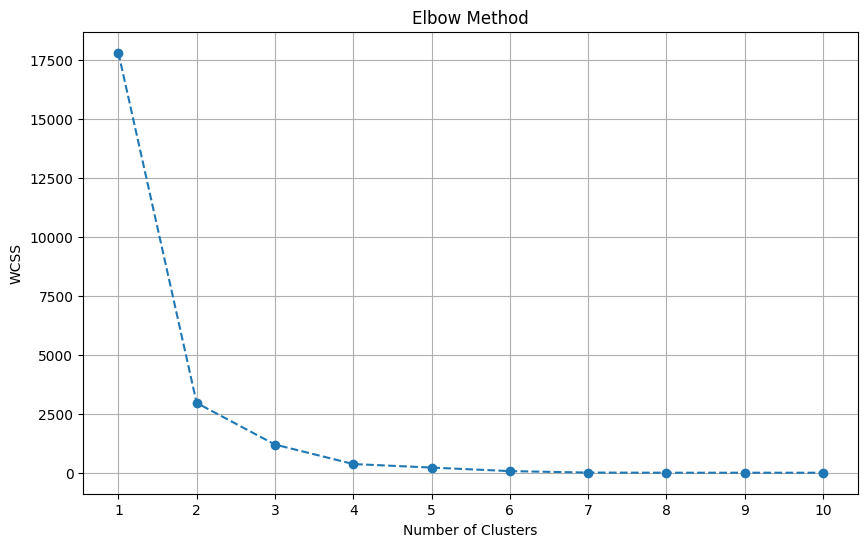

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Assuming 'Risk' is the column you want to analyze
risk_data = df['Risk'].values.reshape(-1, 1)  # Reshape data for clustering

# Find optimal number of clusters using elbow method
wcss = []  # Within-cluster sum of squares
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(risk_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, max_clusters + 1))
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to normalize
# Replace 'column_name' with the actual name of your column

def normalize_column(df, Risk):
    # Copy the DataFrame to avoid modifying the original
    df_normalized = df.copy()

    # Calculate the minimum and maximum values of the column
    min_val = df_normalized[Risk].min()
    max_val = df_normalized[Risk].max()

    # Apply Min-Max scaling to the column
    df_normalized[Risk] = (df_normalized[Risk] - min_val) / (max_val - min_val)

    return df_normalized

# Example usage:
df_normalized = normalize_column(df, 'Risk')

Number of bugs in high risk region: 544
Number of bugs in medium risk region: 543
Number of bugs in low risk region: 598


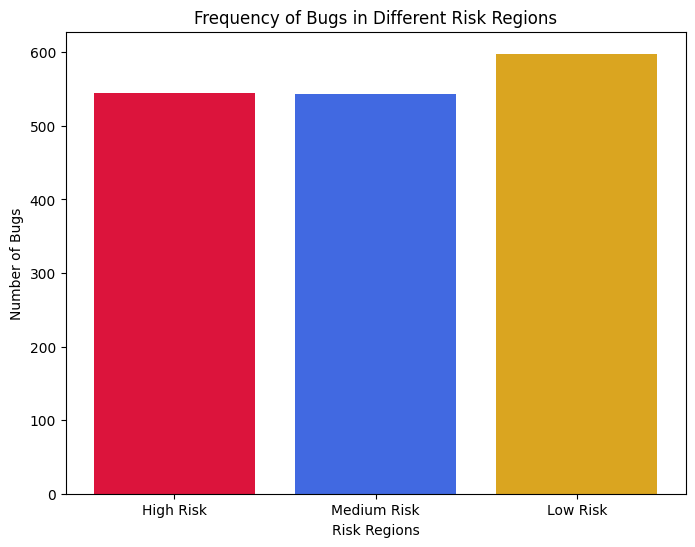

In [ ]:
# Count the number of bugs in each region
high_risk_count = len(df[df['Risk'] > 9])
medium_risk_count = len(df[(df['Risk'] > 5) & (df['Risk'] < 9)])
low_risk_count = len(df[df['Risk'] <= 5])

# Print the counts
print("Number of bugs in high risk region:", high_risk_count)
print("Number of bugs in medium risk region:", medium_risk_count)
print("Number of bugs in low risk region:", low_risk_count)

# Create a bar plot
regions = ['High Risk', 'Medium Risk', 'Low Risk']
bug_counts = [high_risk_count, medium_risk_count, low_risk_count]

plt.figure(figsize=(8, 6))
plt.bar(regions, bug_counts, color=['crimson', 'royalblue', 'goldenrod'])
plt.title('Frequency of Bugs in Different Risk Regions')
plt.xlabel('Risk Regions')
plt.ylabel('Number of Bugs')
plt.show()


In [ ]:
df_normalized.head()

,Bug ID,Product,Component,Assignee,Status,Resolution,Summary,Changed,Depends on,Keywords,Priority,Severity,Classification,Tokenized,String_Tokenized,Summary_wo_Punctuation,Stemmed,ListString,Risk,Risk Category
2,546916,4DIAC,1,4diac-inbox,UNCONFIRMED,---,Repeat shortcut,2019-05-02 09:08:22,NaN,NaN,3,2.0,IoT,"[Repeat, shortcut]",repeat shortcut,"[repeat, shortcut]","[repeat, shortcut]",repeat shortcut,0.222222,3
3,547884,4DIAC,1,4diac-inbox,UNCONFIRMED,---,Improvment of the dynamic type loader,2023-03-30 15:55:31,"547885, 547888, 548396, 548765",NaN,3,2.0,IoT,"[Improvment, of, the, dynamic, type, loader]",improvment dynamic type loader,"[improvment, dynamic, type, loader]","[improv, dynam, type, loader]",improv dynam type loader,0.222222,2
4,548767,4DIAC,1,4diac-inbox,UNCONFIRMED,---,[DTL] Testing Boot File Loader,2019-08-07 06:50:28,NaN,NaN,3,2.0,IoT,"[DTL, Testing, Boot, File, Loader]",dtl testing boot file loader,"[dtl, testing, boot, file, loader]","[dtl, test, boot, file, loader]",dtl test boot file loader,0.222222,2
5,549100,4DIAC,1,4diac-inbox,UNCONFIRMED,---,[DTL] Support StructuredText.CallImpl in Code ...,2023-09-06 16:08:04,NaN,NaN,3,2.0,IoT,"[DTL, Support, in, Code, Generator]",dtl support code generator,"[dtl, support, code, generator]","[dtl, support, code, generat]",dtl support code generat,0.222222,3
6,551140,4DIAC,1,4diac-inbox,UNCONFIRMED,---,Externalize all strings in java files,2020-08-26 08:31:36,NaN,NaN,3,2.0,IoT,"[Externalize, all, strings, in, java, files]",externalize strings java files,"[externalize, strings, java, files]","[extern, string, java, file]",extern string java file,0.222222,2


## Data Preprocessing

In [ ]:
df['Summary']

0       genTestSrcDir in Deployment Assembly causes te...
1       Comparison of  two (identically) Strings are e...
2                                   RSE: security warning
3                                                    test
4                                           dual port bug
                              ...                        
1734    Sorting og numerical values in table is lexico...
1735    Sorting og numerical values in table is lexico...
1736    Sorting og numerical values in table is lexico...
1737    Sorting og numerical values in table is lexico...
1738    Sorting og numerical values in table is lexico...
Name: Summary, Length: 1739, dtype: object

### 1. Tokenization

In [ ]:
def tokenize(column):

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

In [ ]:
df['Tokenized'] = df.apply(lambda x: tokenize(x['Summary']), axis=1)
df

,Bug ID,Product,Component,Assignee,Status,Resolution,Summary,Changed,Priority,Severity,Classification,Risk,Tokenized
0,538561,M2E-WTP,1,m2e-wtp.core-inbox,UNCONFIRMED,---,genTestSrcDir in Deployment Assembly causes te...,2018-09-10 08:24:14,3,2.0,Technology,6.0,"[genTestSrcDir, in, Deployment, Assembly, caus..."
1,538120,RCPTT,2,rcptt-inbox,UNCONFIRMED,---,Comparison of two (identically) Strings are e...,2018-08-21 10:26:10,3,2.0,Technology,6.0,"[Comparison, of, two, identically, Strings, ar..."
2,538320,RCPTT,2,rcptt-inbox,UNCONFIRMED,---,RSE: security warning,2018-08-27 15:39:39,3,3.0,Technology,9.0,"[RSE, security, warning]"
3,538585,z_Archived,3,scada-inbox,UNCONFIRMED,---,test,2021-03-04 17:25:13,3,2.0,Eclipse Foundation,6.0,[test]
4,538149,z_Archived,4,titan-inbox,UNCONFIRMED,---,dual port bug,2021-04-23 10:43:01,3,2.0,Eclipse Foundation,6.0,"[dual, port, bug]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,538197,ECP,51,lkoehler,RESOLVED,FIXED,Sorting og numerical values in table is lexico...,2018-12-20 11:11:55,2,2.0,Modeling,4.0,"[Sorting, og, numerical, values, in, table, is..."
1735,538197,ECP,51,lkoehler,RESOLVED,FIXED,Sorting og numerical values in table is lexico...,2018-12-20 11:11:55,2,2.0,Modeling,4.0,"[Sorting, og, numerical, values, in, table, is..."
1736,538197,ECP,51,lkoehler,RESOLVED,FIXED,Sorting og numerical values in table is lexico...,2018-12-20 11:11:55,2,2.0,Modeling,4.0,"[Sorting, og, numerical, values, in, table, is..."
1737,538197,ECP,51,lkoehler,RESOLVED,FIXED,Sorting og numerical values in table is lexico...,2018-12-20 11:11:55,2,2.0,Modeling,4.0,"[Sorting, og, numerical, values, in, table, is..."


In [ ]:
df['String_Tokenized'] = [' '.join(map(str, l)) for l in df['Tokenized']]
df['String_Tokenized'] = df['String_Tokenized'].apply(str.lower)
df['String_Tokenized']

0       gentestsrcdir in deployment assembly causes te...
1       comparison of two identically strings are exec...
2                                    rse security warning
3                                                    test
4                                           dual port bug
                              ...                        
1734    sorting og numerical values in table is lexico...
1735    sorting og numerical values in table is lexico...
1736    sorting og numerical values in table is lexico...
1737    sorting og numerical values in table is lexico...
1738    sorting og numerical values in table is lexico...
Name: String_Tokenized, Length: 1739, dtype: object

### 2. StopWord Removal

In [ ]:
stop_words = stopwords.words('english')
df['String_Tokenized'] = df['String_Tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['String_Tokenized']

0       gentestsrcdir deployment assembly causes test ...
1       comparison two identically strings executed re...
2                                    rse security warning
3                                                    test
4                                           dual port bug
                              ...                        
1734    sorting og numerical values table lexicographical
1735    sorting og numerical values table lexicographical
1736    sorting og numerical values table lexicographical
1737    sorting og numerical values table lexicographical
1738    sorting og numerical values table lexicographical
Name: String_Tokenized, Length: 1739, dtype: object

In [ ]:
df["Summary_wo_Punctuation"] = df['String_Tokenized'].str.replace('[^\w\s]','')
df['Summary_wo_Punctuation'] = df['Summary_wo_Punctuation'].apply(lambda x: x.replace('"', ''))
df['Summary_wo_Punctuation']

0       gentestsrcdir deployment assembly causes test ...
1       comparison two identically strings executed re...
2                                    rse security warning
3                                                    test
4                                           dual port bug
                              ...                        
1734    sorting og numerical values table lexicographical
1735    sorting og numerical values table lexicographical
1736    sorting og numerical values table lexicographical
1737    sorting og numerical values table lexicographical
1738    sorting og numerical values table lexicographical
Name: Summary_wo_Punctuation, Length: 1739, dtype: object

### 3. Stemming

In [ ]:
# Use English stemmer.
stemmer = SnowballStemmer("english")
df['Summary_wo_Punctuation'] = df['Summary_wo_Punctuation'].str.split()
df['Stemmed'] = df['Summary_wo_Punctuation'].apply(lambda x: [stemmer.stem(y) for y in x])

In [ ]:
df['ListString'] = [' '.join(map(str, l)) for l in df['Stemmed']]
df.head()

,Bug ID,Product,Component,Assignee,Status,Resolution,Summary,Changed,Priority,Severity,Classification,Risk,Tokenized,String_Tokenized,Summary_wo_Punctuation,Stemmed,ListString
0,538561,M2E-WTP,1,m2e-wtp.core-inbox,UNCONFIRMED,---,genTestSrcDir in Deployment Assembly causes te...,2018-09-10 08:24:14,3,2.0,Technology,6.0,"[genTestSrcDir, in, Deployment, Assembly, caus...",gentestsrcdir deployment assembly causes test ...,"[gentestsrcdir, deployment, assembly, causes, ...","[gentestsrcdir, deploy, assembl, caus, test, c...",gentestsrcdir deploy assembl caus test class r...
1,538120,RCPTT,2,rcptt-inbox,UNCONFIRMED,---,Comparison of two (identically) Strings are e...,2018-08-21 10:26:10,3,2.0,Technology,6.0,"[Comparison, of, two, identically, Strings, ar...",comparison two identically strings executed re...,"[comparison, two, identically, strings, execut...","[comparison, two, ident, string, execut, resul...",comparison two ident string execut result fals
2,538320,RCPTT,2,rcptt-inbox,UNCONFIRMED,---,RSE: security warning,2018-08-27 15:39:39,3,3.0,Technology,9.0,"[RSE, security, warning]",rse security warning,"[rse, security, warning]","[rse, secur, warn]",rse secur warn
3,538585,z_Archived,3,scada-inbox,UNCONFIRMED,---,test,2021-03-04 17:25:13,3,2.0,Eclipse Foundation,6.0,[test],test,[test],[test],test
4,538149,z_Archived,4,titan-inbox,UNCONFIRMED,---,dual port bug,2021-04-23 10:43:01,3,2.0,Eclipse Foundation,6.0,"[dual, port, bug]",dual port bug,"[dual, port, bug]","[dual, port, bug]",dual port bug


### 4. TF-IDF

In [ ]:
data = []
for i in df['ListString']:
    review = ''.join(i)
    data.append(review)
print(data)

['gentestsrcdir deploy assembl caus test class resourc deploy', 'comparison two ident string execut result fals', 'rse secur warn', 'test', 'dual port bug', 'wrong export trace file', 'miss header click icon besid disk name column disk activ bar', 'trace analysi stub import fail dialog box display', 'add adapt capabl fmi plugin', 'ajbuild resolv dynam depend', 'design c generat sm c code generat', 'turn index sourc file includ build work reliabl', 'add cdt prefer remov messag build consol output', 'cdt index hang sourc', 'languag map get wrong languag id ad two new languag', 'consol window display output line begin charact', 'coreexcept', 'add support ccls languag server', 'add discuss regard trademark start open sourc project eclips foundat section', 'add section describ member architectur council', 'discoveri jmdns updat latest version jmdns', 'xmpp provid ecf repo instal photon june javae mac os x bit distribut', 'classcastexcept call store procedur get list number', 'branch shown s

In [ ]:
tfidf = TfidfVectorizer()

result = tfidf.fit_transform(data)

In [ ]:
print('\nidf values:')
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    print(ele1, ':', ele2)


idf values:
abl : 5.5712686343124105
accept : 7.363028103540465
access : 5.203543854187092
accommod : 7.76849321164863
account : 7.76849321164863
acknowledg : 7.76849321164863
across : 7.363028103540465
acsl : 7.76849321164863
action : 7.363028103540465
activ : 7.363028103540465
ad : 6.063745119410204
adapt : 7.363028103540465
add : 3.6096101282889577
addit : 7.76849321164863
admin : 7.76849321164863
afm : 7.76849321164863
agent : 7.76849321164863
agil : 7.363028103540465
ahc : 7.76849321164863
aioib : 5.165803526204246
ajbuild : 7.76849321164863
algorithm : 7.363028103540465
align : 6.8522024797744745
aligna : 7.76849321164863
alloc : 7.76849321164863
allow : 7.363028103540465
alphabet : 7.76849321164863
also : 7.76849321164863
altern : 7.76849321164863
alway : 7.363028103540465
ambigu : 7.76849321164863
amount : 7.76849321164863
amp : 7.76849321164863
analysi : 7.363028103540465
analyz : 5.5712686343124105
annot : 6.5157302431532615
anoth : 6.8522024797744745
ant : 7.76849321164863


In [ ]:
print('\nWord indexes:')
print(tfidf.vocabulary_)


Word indexes:
{'gentestsrcdir': 430, 'deploy': 261, 'assembl': 64, 'caus': 136, 'test': 1033, 'class': 152, 'resourc': 894, 'comparison': 182, 'two': 1078, 'ident': 496, 'string': 996, 'execut': 361, 'result': 900, 'fals': 377, 'rse': 912, 'secur': 932, 'warn': 1144, 'dual': 304, 'port': 794, 'bug': 113, 'wrong': 1172, 'export': 369, 'trace': 1058, 'file': 386, 'miss': 672, 'header': 465, 'click': 160, 'icon': 491, 'besid': 89, 'disk': 283, 'name': 692, 'column': 172, 'activ': 9, 'bar': 81, 'analysi': 33, 'stub': 1000, 'import': 503, 'fail': 375, 'dialog': 273, 'box': 103, 'display': 284, 'add': 12, 'adapt': 11, 'capabl': 133, 'fmi': 397, 'plugin': 787, 'ajbuild': 20, 'resolv': 893, 'dynam': 308, 'depend': 260, 'design': 268, 'generat': 425, 'sm': 960, 'code': 166, 'turn': 1075, 'index': 514, 'sourc': 966, 'includ': 507, 'build': 116, 'work': 1163, 'reliabl': 874, 'cdt': 140, 'prefer': 804, 'remov': 877, 'messag': 662, 'consol': 202, 'output': 751, 'hang': 460, 'languag': 587, 'map': 

In [ ]:
print('\ntf-idf value:')
print(result)


tf-idf value:
  (0, 894)	0.3126948200733332
  (0, 152)	0.2729721241119333
  (0, 1033)	0.22259713297490089
  (0, 136)	0.2936859591221484
  (0, 64)	0.3641995434562983
  (0, 261)	0.6634073620490362
  (0, 430)	0.3451906825051135
  (1, 377)	0.3749235676472134
  (1, 900)	0.25803517780590907
  (1, 361)	0.36625853696623795
  (1, 996)	0.38517212370413884
  (1, 496)	0.4366781392032611
  (1, 1078)	0.38517212370413884
  (1, 182)	0.4138863642609815
  (2, 1144)	0.5304479649349387
  (2, 932)	0.5994267914000767
  (2, 912)	0.5994267914000767
  (3, 1033)	1.0
  (4, 113)	0.512141550892014
  (4, 794)	0.590848502298905
  (4, 304)	0.6233851772227692
  (5, 386)	0.45679413405357094
  (5, 1058)	0.5624323682910992
  (5, 369)	0.5624323682910992
  (5, 1172)	0.39834505305222384
  :	:
  (1734, 1118)	0.40706553528646294
  (1735, 603)	0.4090927434350719
  (1735, 1020)	0.4080743581385504
  (1735, 717)	0.4090927434350719
  (1735, 730)	0.4090927434350719
  (1735, 963)	0.40706553528646294
  (1735, 1118)	0.407065535286462

In [ ]:
print('\ntf-idf values in matrix form:')
tfIdf_mat = result.toarray()
print(tfIdf_mat)


tf-idf values in matrix form:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
words_set = tfidf.get_feature_names_out()

print(words_set)

['abl' 'accept' 'access' ... 'xtext' 'zip' 'zoom']


In [ ]:
df_tf_idf = pd.DataFrame(tfIdf_mat, columns = words_set)

df_tf_idf

,abl,accept,access,accommod,account,acknowledg,across,acsl,action,activ,...,xdebug,xmlelement,xmlidref,xmpp,xmppath,xpect,xsd,xtext,zip,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np

# Replace "--" with NaN
df_tf_idf.replace("--", np.nan, inplace=True)

# Drop rows with NaN values
df_tf_idf.dropna(inplace=True)

# Now, "--" should be removed from your DataFrame

##Creating New Dataframe

In [ ]:
df.shape

(1739, 17)

In [ ]:
# Copy the DataFrame to preserve the original
dataset = df_tf_idf.copy()

# Reset the indices of both DataFrames
df.reset_index(drop=True, inplace=True)
dataset.reset_index(drop=True, inplace=True)

# Define the columns to add
# priority_column = df['Priority']
risk_column = df['Risk']

# Concatenate the columns to the end of the dataset
dataset = pd.concat([dataset, risk_column], axis=1)


In [ ]:
df['Risk'].unique()

array([ 6.,  9., 12.,  3., 15.,  4.,  8., 10.])

In [ ]:
dataset.head()

,abl,accept,access,accommod,account,acknowledg,across,acsl,action,activ,...,xmlelement,xmlidref,xmpp,xmppath,xpect,xsd,xtext,zip,zoom,Risk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [ ]:
# Check the data types of the 'Risk' column in both DataFrames
print(df['Risk'].dtype)
print(dataset['Risk'].dtype)

# Check for NaN values in 'Risk' column of df
print(df['Risk'].isna().sum())

# Check for NaN values in 'Risk' column of dataset
print(dataset['Risk'].isna().sum())


float64
float64
0
0


## Applying ACO

### ACO + KNN for Feature Selection

Iteration 1/10: Best Accuracy = 0.5376884422110553
Iteration 2/10: Best Accuracy = 0.5376884422110553
Iteration 3/10: Best Accuracy = 0.5829145728643216
Iteration 4/10: Best Accuracy = 0.5829145728643216
Iteration 5/10: Best Accuracy = 0.6884422110552764
Iteration 6/10: Best Accuracy = 0.6884422110552764
Iteration 7/10: Best Accuracy = 0.6884422110552764
Iteration 8/10: Best Accuracy = 0.6934673366834171
Iteration 9/10: Best Accuracy = 0.6934673366834171
Iteration 10/10: Best Accuracy = 0.6934673366834171


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy after ACO feature selection with KNN classifier: 0.6934673366834171
Classification Report:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00        40
         6.0       0.64      1.00      0.78       107
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00        11
        10.0       1.00      1.00      1.00        31
        12.0       0.00      0.00      0.00         3
        15.0       0.00      0.00      0.00         4

    accuracy                           0.69       199
   macro avg       0.20      0.25      0.22       199
weighted avg       0.50      0.69      0.57       199



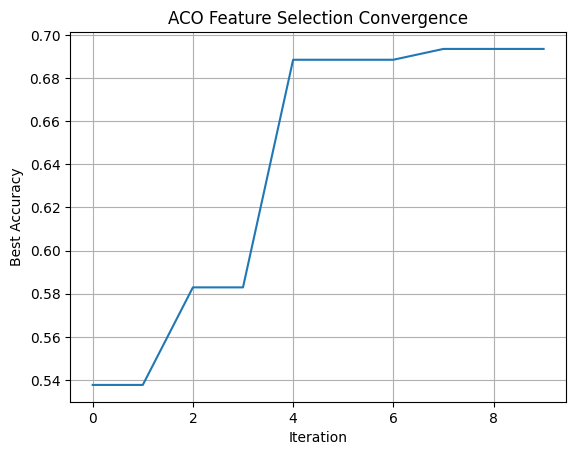

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score

def compute_heuristic_values(xtrain, ytrain):
    return mutual_info_classif(xtrain, ytrain)

def initialize_pheromone_matrix(num_features, tau0):
    return np.ones((num_features,), dtype=float) * tau0

def update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho):
    delta_tau = np.dot(ant_features.T, ant_accuracies) / num_valid
    return (1 - rho) * tau + delta_tau

def select_features(probabilities, remaining_features, q0):
    if np.random.rand() < q0:
        return np.argmax(probabilities)
    else:
        selected_feature = np.random.choice(remaining_features, p=probabilities)
        return selected_feature

def aco_feature_selection(xtrain, ytrain, xvalid, yvalid, opts, heuristic_values):
    num_ants = opts['num_ants']
    max_iter = opts['max_iter']
    alpha = opts['alpha']
    beta = opts['beta']
    rho = opts['rho']
    q0 = opts['q0']
    tau0 = opts['tau0']

    num_features = xtrain.shape[1]
    num_valid = len(yvalid)
    tau = initialize_pheromone_matrix(num_features, tau0)
    best_features = np.zeros((num_features,), dtype=int)
    best_accuracy = 0.0
    history = np.zeros((max_iter,), dtype=float)

    for iteration in range(max_iter):
        ant_accuracies = []
        ant_features = np.zeros((num_ants, num_features), dtype=int)

        for ant in range(num_ants):
            ant_solution = np.zeros((num_features,), dtype=int)
            remaining_features = np.arange(num_features)

            selected_indices = np.random.choice(remaining_features, size=opts['k'], replace=False)
            ant_solution[selected_indices] = 1

            x_train_subset = xtrain[:, selected_indices]
            x_valid_subset = xvalid[:, selected_indices]

            mdl = KNeighborsClassifier(n_neighbors=opts['k'])
            mdl.fit(x_train_subset, ytrain)
            y_pred = mdl.predict(x_valid_subset)
            accuracy = accuracy_score(yvalid, y_pred)
            ant_accuracies.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_features = ant_solution

        tau = update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho)
        history[iteration] = best_accuracy
        print(f"Iteration {iteration + 1}/{max_iter}: Best Accuracy = {best_accuracy}")

    return best_features, history

# Load data
data = dataset.values
feat = data[:, :-1]
label = data[:, -1]

# Find classes with only one member
unique_classes, class_counts = np.unique(label, return_counts=True)
classes_with_one_member = unique_classes[class_counts == 1]

# Remove samples from classes with only one member
for class_label in classes_with_one_member:
    label_indices = np.where(label == class_label)[0]
    feat = np.delete(feat, label_indices, axis=0)
    label = np.delete(label, label_indices)

# Split data into train and validation sets
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.2, stratify=label)

# Compute heuristic values
heuristic_values = compute_heuristic_values(xtrain, ytrain)

# Parameters
opts = {
    'k': 5,
    'num_ants': 100,
    'max_iter': 10,
    'alpha': 1.0,
    'beta': 2.0,
    'rho': 0.5,
    'q0': 0.9,
    'tau0': 0.1
}

# Perform feature selection using ACO
selected_features, history = aco_feature_selection(xtrain, ytrain, xtest, ytest, opts, heuristic_values)

# Evaluate selected features
selected_indices = np.where(selected_features == 1)[0]
x_train_selected = xtrain[:, selected_indices]
x_test_selected = xtest[:, selected_indices]

# Train KNN model with selected features
mdl = KNeighborsClassifier(n_neighbors=opts['k'])
mdl.fit(x_train_selected, ytrain)

# Evaluate accuracy, F1 score, and recall score
y_pred = mdl.predict(x_test_selected)
accuracy = np.sum(y_pred == ytest) / len(ytest)
unique_labels = np.unique(label).astype(str)
report = classification_report(ytest, y_pred, target_names=unique_labels)
print("Accuracy after ACO feature selection with KNN classifier:", accuracy)
print("Classification Report:\n", report)

# Plot convergence curve
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy')
plt.title('ACO Feature Selection Convergence')
plt.grid(True)
plt.show()

### ACO + NB for Feature Selection

Iteration 1/10: Best Accuracy = 0.6834170854271356
Iteration 2/10: Best Accuracy = 0.7185929648241206
Iteration 3/10: Best Accuracy = 0.7185929648241206
Iteration 4/10: Best Accuracy = 0.7185929648241206
Iteration 5/10: Best Accuracy = 0.7185929648241206
Iteration 6/10: Best Accuracy = 0.7185929648241206
Iteration 7/10: Best Accuracy = 0.7185929648241206
Iteration 8/10: Best Accuracy = 0.7185929648241206
Iteration 9/10: Best Accuracy = 0.7185929648241206
Iteration 10/10: Best Accuracy = 0.7185929648241206
Accuracy after ACO feature selection with Naive Bayes classifier: 0.7185929648241206
Classification Report:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.73      1.00      0.84        40
         6.0       0.85      0.66      0.74       107
         8.0       0.00      0.00      0.00         1
         9.0       0.10      0.09      0.10        11
        10.0       1.00      1.00      1.00        31
 

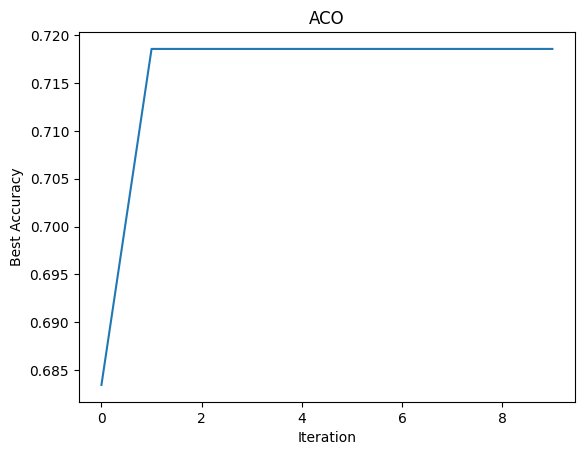

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

def compute_heuristic_values(xtrain, ytrain):
    return mutual_info_classif(xtrain, ytrain)

def initialize_pheromone_matrix(num_features, tau0):
    return np.ones((num_features,), dtype=float) * tau0

def update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho):
    delta_tau = np.dot(ant_features.T, ant_accuracies) / num_valid
    return (1 - rho) * tau + delta_tau

def select_features(probabilities, remaining_features, q0):
    if np.random.rand() < q0:
        return np.argmax(probabilities)
    else:
        selected_feature = np.random.choice(remaining_features, p=probabilities)
        return selected_feature

def aco_feature_selection(xtrain, ytrain, xvalid, yvalid, opts, heuristic_values):
    num_ants = opts['num_ants']
    max_iter = opts['max_iter']
    alpha = opts['alpha']
    beta = opts['beta']
    rho = opts['rho']
    q0 = opts['q0']
    tau0 = opts['tau0']

    num_features = xtrain.shape[1]
    num_valid = len(yvalid)
    tau = initialize_pheromone_matrix(num_features, tau0)
    best_features = np.zeros((num_features,), dtype=int)
    best_accuracy = 0.0
    history = np.zeros((max_iter,), dtype=float)

    for iteration in range(max_iter):
        ant_accuracies = []
        ant_features = np.zeros((num_ants, num_features), dtype=int)

        for ant in range(num_ants):
            ant_solution = np.zeros((num_features,), dtype=int)
            remaining_features = np.arange(num_features)

            for _ in range(num_features):
                probabilities = (tau[remaining_features] * alpha) * (heuristic_values[remaining_features] * beta)
                probabilities /= np.sum(probabilities)
                selected_feature = select_features(probabilities, remaining_features, q0)
                ant_solution[selected_feature] = 1
                remaining_features = np.delete(remaining_features, np.where(remaining_features == selected_feature))

            selected_indices = np.where(ant_solution == 1)[0]
            x_train_subset = xtrain[:, selected_indices]
            x_valid_subset = xvalid[:, selected_indices]
            mdl = GaussianNB()  # Use Naive Bayes for classification
            mdl.fit(x_train_subset, ytrain)
            y_pred = mdl.predict(x_valid_subset)
            accuracy = np.sum(y_pred == yvalid) / num_valid
            ant_accuracies.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_features = ant_solution

        tau = update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho)
        history[iteration] = best_accuracy
        print(f"Iteration {iteration + 1}/{max_iter}: Best Accuracy = {best_accuracy}")

    return best_features, history

# Load data
# Assuming dataset is already loaded into 'dataset' variable
data = dataset.values
feat = data[:, :-1]
label = data[:, -1]

# Find classes with only one member
unique_classes, class_counts = np.unique(label, return_counts=True)
classes_with_one_member = unique_classes[class_counts == 1]

# Remove samples from classes with only one member
for class_label in classes_with_one_member:
    label_indices = np.where(label == class_label)[0]
    feat = np.delete(feat, label_indices, axis=0)
    label = np.delete(label, label_indices)

# Split data into train and validation sets
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.2, stratify=label)

# Compute heuristic values
heuristic_values = compute_heuristic_values(xtrain, ytrain)

# Parameters
opts = {
    'num_ants': 100,
    'max_iter': 10,
    'alpha': 1.0,
    'beta': 2.0,
    'rho': 0.5,
    'q0': 0.9,
    'tau0': 0.1
}

# Perform feature selection using ACO with Naive Bayes classifier
selected_features, history = aco_feature_selection(xtrain, ytrain, xtest, ytest, opts, heuristic_values)

# Select features based on ACO results
selected_indices = np.where(selected_features == 1)[0]
x_train_selected = xtrain[:, selected_indices]
x_test_selected = xtest[:, selected_indices]

# Train Naive Bayes model with selected features
mdl = GaussianNB()
mdl.fit(x_train_selected, ytrain)

# Evaluate accuracy
y_pred = mdl.predict(x_test_selected)
accuracy = np.sum(y_pred == ytest) / len(ytest)
unique_labels = np.unique(label).astype(str)
report = classification_report(ytest, y_pred, target_names=unique_labels)
print("Accuracy after ACO feature selection with Naive Bayes classifier:", accuracy)
print("Classification Report:\n", report)

# Plot convergence curve
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy')
plt.title('ACO')
plt.show()

### ACO + Decision Tree for Feature Selection

Iteration 1/10: Best Accuracy = 0.8693467336683417
Iteration 2/10: Best Accuracy = 0.8844221105527639
Iteration 3/10: Best Accuracy = 0.8844221105527639
Iteration 4/10: Best Accuracy = 0.8844221105527639
Iteration 5/10: Best Accuracy = 0.8894472361809045
Iteration 6/10: Best Accuracy = 0.8894472361809045
Iteration 7/10: Best Accuracy = 0.8894472361809045
Iteration 8/10: Best Accuracy = 0.8894472361809045
Iteration 9/10: Best Accuracy = 0.8894472361809045
Iteration 10/10: Best Accuracy = 0.8894472361809045


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy after ACO feature selection with Decision Tree classifier: 0.8693467336683417
Classification Report:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       1.00      1.00      1.00        40
         6.0       0.85      0.93      0.89       107
         8.0       1.00      1.00      1.00         1
         9.0       0.17      0.09      0.12        11
        10.0       1.00      1.00      1.00        31
        12.0       0.00      0.00      0.00         3
        15.0       0.00      0.00      0.00         4

    accuracy                           0.87       199
   macro avg       0.50      0.50      0.50       199
weighted avg       0.83      0.87      0.85       199



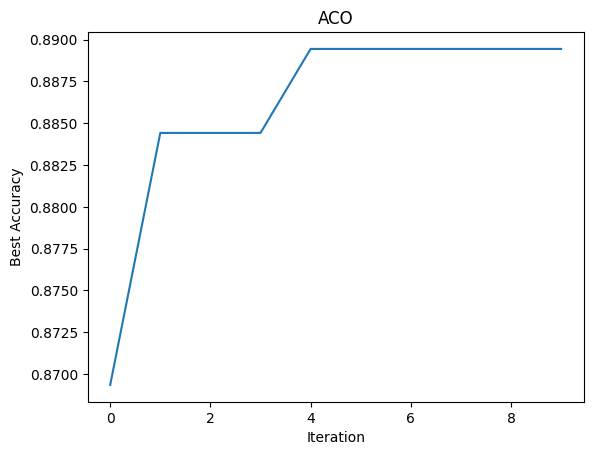

In [ ]:
import numpy as np #decision tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

def compute_heuristic_values(xtrain, ytrain):
    return mutual_info_classif(xtrain, ytrain)

def initialize_pheromone_matrix(num_features, tau0):
    return np.ones((num_features,), dtype=float) * tau0

def update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho):
    delta_tau = np.dot(ant_features.T, ant_accuracies) / num_valid
    return (1 - rho) * tau + delta_tau

def select_features(probabilities, remaining_features, q0):
    if np.random.rand() < q0:
        return np.argmax(probabilities)
    else:
        selected_feature = np.random.choice(remaining_features, p=probabilities)
        return selected_feature

def aco_feature_selection(xtrain, ytrain, xvalid, yvalid, opts, heuristic_values):
    num_ants = opts['num_ants']
    max_iter = opts['max_iter']
    alpha = opts['alpha']
    beta = opts['beta']
    rho = opts['rho']
    q0 = opts['q0']
    tau0 = opts['tau0']

    num_features = xtrain.shape[1]
    num_valid = len(yvalid)
    tau = initialize_pheromone_matrix(num_features, tau0)
    best_features = np.zeros((num_features,), dtype=int)
    best_accuracy = 0.0
    history = np.zeros((max_iter,), dtype=float)

    for iteration in range(max_iter):
        ant_accuracies = []
        ant_features = np.zeros((num_ants, num_features), dtype=int)

        for ant in range(num_ants):
            ant_solution = np.zeros((num_features,), dtype=int)
            remaining_features = np.arange(num_features)

            for _ in range(num_features):
                probabilities = (tau[remaining_features] * alpha) * (heuristic_values[remaining_features] * beta)
                probabilities /= np.sum(probabilities)
                selected_feature = select_features(probabilities, remaining_features, q0)
                ant_solution[selected_feature] = 1
                remaining_features = np.delete(remaining_features, np.where(remaining_features == selected_feature))

            selected_indices = np.where(ant_solution == 1)[0]
            x_train_subset = xtrain[:, selected_indices]
            x_valid_subset = xvalid[:, selected_indices]
            mdl = DecisionTreeClassifier()  # Use Decision Tree for classification
            mdl.fit(x_train_subset, ytrain)
            y_pred = mdl.predict(x_valid_subset)
            accuracy = np.sum(y_pred == yvalid) / num_valid
            ant_accuracies.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_features = ant_solution

        tau = update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho)
        history[iteration] = best_accuracy
        print(f"Iteration {iteration + 1}/{max_iter}: Best Accuracy = {best_accuracy}")

    return best_features, history

# Load data
data = dataset.values
feat = data[:, :-1]
label = data[:, -1]

# Find classes with only one member
unique_classes, class_counts = np.unique(label, return_counts=True)
classes_with_one_member = unique_classes[class_counts == 1]

# Remove samples from classes with only one member
for class_label in classes_with_one_member:
    label_indices = np.where(label == class_label)[0]
    feat = np.delete(feat, label_indices, axis=0)
    label = np.delete(label, label_indices)

# Split data into train and validation sets
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.2, stratify=label)

# Compute heuristic values
heuristic_values = compute_heuristic_values(xtrain, ytrain)

# Parameters
opts = {
    'num_ants': 100,
    'max_iter': 10,
    'alpha': 1.0,
    'beta': 2.0,
    'rho': 0.5,
    'q0': 0.9,
    'tau0': 0.1
}

# Perform feature selection using ACO with Decision Tree classifier
selected_features, history = aco_feature_selection(xtrain, ytrain, xtest, ytest, opts, heuristic_values)

# Perform Recursive Feature Elimination (RFE) with Decision Tree classifier for final feature selection
dt = DecisionTreeClassifier()
rfe = RFE(estimator=dt, n_features_to_select=np.sum(selected_features), step=1)
x_train_selected = rfe.fit_transform(xtrain, ytrain)
x_test_selected = rfe.transform(xtest)

# Train Decision Tree model with selected features
mdl = DecisionTreeClassifier()
mdl.fit(x_train_selected, ytrain)

# Evaluate accuracy, precision, recall, and F1 score
y_pred = mdl.predict(x_test_selected)
accuracy = np.sum(y_pred == ytest) / len(ytest)
unique_labels = np.unique(label).astype(str)
report = classification_report(ytest, y_pred, target_names=unique_labels)
print("Accuracy after ACO feature selection with Decision Tree classifier:", accuracy)
print("Classification Report:\n", report)

# Plot convergence curve
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy')
plt.title('ACO')
plt.show()

### ACO + Random Forest for Feature Selection

Iteration 1/10: Best Accuracy = 0.8844221105527639
Iteration 2/10: Best Accuracy = 0.8944723618090452
Iteration 3/10: Best Accuracy = 0.8944723618090452
Iteration 4/10: Best Accuracy = 0.8994974874371859
Iteration 5/10: Best Accuracy = 0.8994974874371859
Iteration 6/10: Best Accuracy = 0.8994974874371859
Iteration 7/10: Best Accuracy = 0.8994974874371859
Iteration 8/10: Best Accuracy = 0.8994974874371859
Iteration 9/10: Best Accuracy = 0.8994974874371859
Iteration 10/10: Best Accuracy = 0.8994974874371859


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy after ACO feature selection with Random Forest classifier: 0.8944723618090452
Classification Report:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       1.00      1.00      1.00        40
         6.0       0.84      1.00      0.91       107
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00        11
        10.0       1.00      1.00      1.00        31
        12.0       0.00      0.00      0.00         3
        15.0       0.00      0.00      0.00         4

    accuracy                           0.89       199
   macro avg       0.35      0.38      0.36       199
weighted avg       0.81      0.89      0.85       199



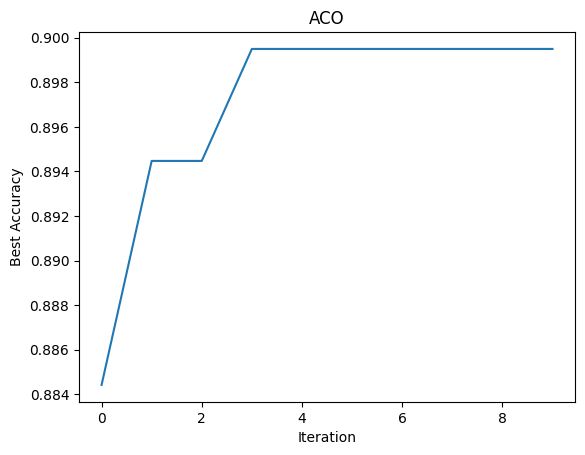

In [ ]:
#rf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def compute_heuristic_values(xtrain, ytrain):
    return mutual_info_classif(xtrain, ytrain)

def initialize_pheromone_matrix(num_features, tau0):
    return np.ones((num_features,), dtype=float) * tau0

def update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho):
    delta_tau = np.dot(ant_features.T, ant_accuracies) / num_valid
    return (1 - rho) * tau + delta_tau

def select_features(probabilities, remaining_features, q0):
    if np.random.rand() < q0:
        return np.argmax(probabilities)
    else:
        selected_feature = np.random.choice(remaining_features, p=probabilities)
        return selected_feature

def aco_feature_selection(xtrain, ytrain, xvalid, yvalid, opts, heuristic_values):
    num_ants = opts['num_ants']
    max_iter = opts['max_iter']
    alpha = opts['alpha']
    beta = opts['beta']
    rho = opts['rho']
    q0 = opts['q0']
    tau0 = opts['tau0']

    num_features = xtrain.shape[1]
    num_valid = len(yvalid)
    tau = initialize_pheromone_matrix(num_features, tau0)
    best_features = np.zeros((num_features,), dtype=int)
    best_accuracy = 0.0
    history = np.zeros((max_iter,), dtype=float)

    for iteration in range(max_iter):
        ant_accuracies = []
        ant_features = np.zeros((num_ants, num_features), dtype=int)

        for ant in range(num_ants):
            ant_solution = np.zeros((num_features,), dtype=int)
            remaining_features = np.arange(num_features)

            for _ in range(num_features):
                probabilities = (tau[remaining_features] * alpha) * (heuristic_values[remaining_features] * beta)
                probabilities /= np.sum(probabilities)
                selected_feature = select_features(probabilities, remaining_features, q0)
                ant_solution[selected_feature] = 1
                remaining_features = np.delete(remaining_features, np.where(remaining_features == selected_feature))

            selected_indices = np.where(ant_solution == 1)[0]
            x_train_subset = xtrain[:, selected_indices]
            x_valid_subset = xvalid[:, selected_indices]
            mdl = RandomForestClassifier(n_estimators=100, random_state=42)  # Use Random Forest for classification
            mdl.fit(x_train_subset, ytrain)
            y_pred = mdl.predict(x_valid_subset)
            accuracy = np.sum(y_pred == yvalid) / num_valid
            ant_accuracies.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_features = ant_solution

        tau = update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho)
        history[iteration] = best_accuracy
        print(f"Iteration {iteration + 1}/{max_iter}: Best Accuracy = {best_accuracy}")

    return best_features, history

# Load data
data = dataset.values
feat = data[:, :-1]
label = data[:, -1]

# Find classes with only one member
unique_classes, class_counts = np.unique(label, return_counts=True)
classes_with_one_member = unique_classes[class_counts == 1]

# Remove samples from classes with only one member
for class_label in classes_with_one_member:
    label_indices = np.where(label == class_label)[0]
    feat = np.delete(feat, label_indices, axis=0)
    label = np.delete(label, label_indices)

# Split data into train and validation sets
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.2, stratify=label)

# Compute heuristic values
heuristic_values = compute_heuristic_values(xtrain, ytrain)

# Parameters
opts = {
    'num_ants': 100,
    'max_iter': 10,
    'alpha': 1.0,
    'beta': 2.0,
    'rho': 0.5,
    'q0': 0.9,
    'tau0': 0.1
}

# Perform feature selection using ACO with Random Forest classifier
selected_features, history = aco_feature_selection(xtrain, ytrain, xtest, ytest, opts, heuristic_values)

# Perform Recursive Feature Elimination (RFE) with Random Forest classifier for final feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=np.sum(selected_features), step=1)
x_train_selected = rfe.fit_transform(xtrain, ytrain)
x_test_selected = rfe.transform(xtest)

# Train Random Forest model with selected features
mdl = RandomForestClassifier(n_estimators=100, random_state=42)
mdl.fit(x_train_selected, ytrain)

# Evaluate accuracy
y_pred = mdl.predict(x_test_selected)
accuracy = np.sum(y_pred == ytest) / len(ytest)
unique_labels = np.unique(label).astype(str)
report = classification_report(ytest, y_pred, target_names=unique_labels)
print("Accuracy after ACO feature selection with Random Forest classifier:", accuracy)
print("Classification Report:\n", report)

# Plot convergence curve
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy')
plt.title('ACO')
plt.show()

### ACO + SVM for Feature Selection

In [ ]:
dataset.shape

(995, 1186)

Iteration 1/10: Best Accuracy = 0.8963210702341137
Iteration 2/10: Best Accuracy = 0.8963210702341137
Iteration 3/10: Best Accuracy = 0.8963210702341137
Iteration 4/10: Best Accuracy = 0.8963210702341137
Iteration 5/10: Best Accuracy = 0.8963210702341137
Iteration 6/10: Best Accuracy = 0.8963210702341137
Iteration 7/10: Best Accuracy = 0.8963210702341137
Iteration 8/10: Best Accuracy = 0.8963210702341137
Iteration 9/10: Best Accuracy = 0.8963210702341137
Iteration 10/10: Best Accuracy = 0.8963210702341137


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy after ACO and RFE feature selection with SVM classifier: 0.8963210702341137
Classification Report after ACO and RFE:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       1.00      1.00      1.00        60
         6.0       0.84      1.00      0.91       161
         8.0       0.00      0.00      0.00         2
         9.0       0.00      0.00      0.00        16
        10.0       1.00      1.00      1.00        47
        12.0       0.00      0.00      0.00         5
        15.0       0.00      0.00      0.00         5

    accuracy                           0.90       299
   macro avg       0.35      0.38      0.36       299
weighted avg       0.81      0.90      0.85       299



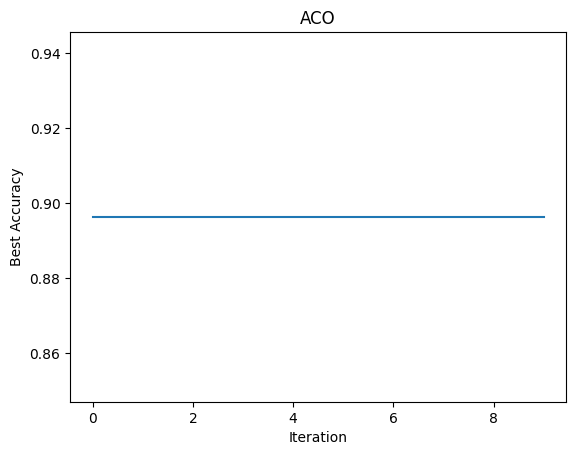

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def compute_heuristic_values(xtrain, ytrain):
    return mutual_info_classif(xtrain, ytrain)

def initialize_pheromone_matrix(num_features, tau0):
    return np.ones((num_features,), dtype=float) * tau0

def update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho):
    delta_tau = np.dot(ant_features.T, ant_accuracies) / num_valid
    return (1 - rho) * tau + delta_tau

def select_features(probabilities, remaining_features, q0):
    if np.random.rand() < q0:
        return np.argmax(probabilities)
    else:
        selected_feature = np.random.choice(remaining_features, p=probabilities)
        return selected_feature

def aco_feature_selection(xtrain, ytrain, xvalid, yvalid, opts, heuristic_values):
    num_ants = opts['num_ants']
    max_iter = opts['max_iter']
    alpha = opts['alpha']
    beta = opts['beta']
    rho = opts['rho']
    q0 = opts['q0']
    tau0 = opts['tau0']

    num_features = xtrain.shape[1]
    num_valid = len(yvalid)
    tau = initialize_pheromone_matrix(num_features, tau0)
    best_features = np.zeros((num_features,), dtype=int)
    best_accuracy = 0.0
    history = np.zeros((max_iter,), dtype=float)

    for iteration in range(max_iter):
        ant_accuracies = []
        ant_features = np.zeros((num_ants, num_features), dtype=int)

        for ant in range(num_ants):
            ant_solution = np.zeros((num_features,), dtype=int)
            remaining_features = np.arange(num_features)

            for _ in range(num_features):
                probabilities = (tau[remaining_features] ** alpha) * (heuristic_values[remaining_features] ** beta)
                probabilities /= np.sum(probabilities)
                selected_feature = select_features(probabilities, remaining_features, q0)
                ant_solution[selected_feature] = 1
                remaining_features = np.delete(remaining_features, np.where(remaining_features == selected_feature))

            selected_indices = np.where(ant_solution == 1)[0]
            x_train_subset = xtrain[:, selected_indices]
            x_valid_subset = xvalid[:, selected_indices]
            mdl = SVC(kernel='linear')  # Use SVM for classification
            mdl.fit(x_train_subset, ytrain)
            y_pred = mdl.predict(x_valid_subset)
            accuracy = np.sum(y_pred == yvalid) / num_valid
            ant_accuracies.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_features = ant_solution

        tau = update_pheromone(tau, ant_features, ant_accuracies, num_valid, rho)
        history[iteration] = best_accuracy
        print(f"Iteration {iteration + 1}/{max_iter}: Best Accuracy = {best_accuracy}")

    return best_features, history

# Load data
# Assuming dataset is already loaded into 'dataset' variable
data = dataset.values
feat = data[:, :-1]
label = data[:, -1]

# Find classes with only one member
unique_classes, class_counts = np.unique(label, return_counts=True)
classes_with_one_member = unique_classes[class_counts == 1]

# Remove samples from classes with only one member
for class_label in classes_with_one_member:
    label_indices = np.where(label == class_label)[0]
    feat = np.delete(feat, label_indices, axis=0)
    label = np.delete(label, label_indices)

# Split data into train and validation sets
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3, stratify=label)


# Compute heuristic values
heuristic_values = compute_heuristic_values(xtrain, ytrain)

# Parameters
opts = {
    'num_ants': 100,
    'max_iter': 10,
    'alpha': 1.0,
    'beta': 2.0,
    'rho': 0.5,
    'q0': 0.9,
    'tau0': 0.1
}

# Perform feature selection using ACO with SVM classifier
selected_features, history = aco_feature_selection(xtrain, ytrain, xtest, ytest, opts, heuristic_values)

# Perform Recursive Feature Elimination (RFE) with SVM classifier for final feature selection
svc = SVC(kernel='linear')
rfe = RFE(estimator=svc, n_features_to_select=np.sum(selected_features), step=1)
x_train_selected = rfe.fit_transform(xtrain, ytrain)
x_test_selected = rfe.transform(xtest)

# Train SVM model with selected features
svc.fit(x_train_selected, ytrain)

# Evaluate accuracy
y_pred = svc.predict(x_test_selected)
accuracy = np.sum(y_pred == ytest) / len(ytest)

# Generate classification report
unique_labels = np.unique(label).astype(str)
report = classification_report(ytest, y_pred, target_names=unique_labels)
print("Accuracy after ACO and RFE feature selection with SVM classifier:", accuracy)
print("Classification Report after ACO and RFE:\n", report)

# Plot convergence curve
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy')
plt.title('ACO')
plt.show()


### Print Selected Features

In [ ]:
# Evaluate selected features
selected_indices = np.where(selected_features == 1)[0]
selected_feature_names = dataset.columns[selected_indices]
print("Selected Features:", selected_feature_names)

print(selected_features)
print(len(selected_features))

Selected Features: Index(['account', 'across', 'action', 'add', 'addit', 'aligna', 'anymor',
       'appli', 'bash', 'basic',
       ...
       'updat', 'valu', 'verif', 'virtualdn', 'virtualmachin', 'websit',
       'welcom', 'well', 'wrap', 'zoom'],
      dtype='object', length=619)
[0 0 0 ... 0 0 1]
1185


## Classification after ACO Feature Selection

### KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(x_train_selected, ytrain)

# Evaluate accuracy
y_pred_knn = knn_classifier.predict(x_test_selected)
from sklearn.metrics import classification_report

# Generate classification report
classification_rep = classification_report(ytest, y_pred_knn)
print("Classification Report for KNN classifier:\n", classification_rep)


Classification Report for KNN classifier:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       1.00      1.00      1.00        60
         6.0       0.84      1.00      0.91       161
         8.0       0.00      0.00      0.00         2
         9.0       0.00      0.00      0.00        16
        10.0       1.00      1.00      1.00        47
        12.0       0.00      0.00      0.00         5
        15.0       0.00      0.00      0.00         5

    accuracy                           0.90       299
   macro avg       0.35      0.38      0.36       299
weighted avg       0.81      0.90      0.85       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayes Classifier

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes model with selected features
nb_classifier = GaussianNB()
nb_classifier.fit(x_train_selected, ytrain)

# Evaluate accuracy
y_pred_nb = nb_classifier.predict(x_test_selected)

# Generate classification report for Naive Bayes classifier
classification_rep_nb = classification_report(ytest, y_pred_nb)
accuracy_nb = accuracy_score(ytest, y_pred_nb)
print("Classification Report for Naive Bayes classifier:\n", classification_rep_nb)

Classification Report for Naive Bayes classifier:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.74      1.00      0.85        60
         6.0       0.82      0.70      0.75       161
         8.0       0.00      0.00      0.00         2
         9.0       0.06      0.06      0.06        16
        10.0       1.00      1.00      1.00        47
        12.0       0.25      0.20      0.22         5
        15.0       0.00      0.00      0.00         5

    accuracy                           0.74       299
   macro avg       0.36      0.37      0.36       299
weighted avg       0.75      0.74      0.74       299



### Random Forest Classifier  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_selected, ytrain)

# Evaluate accuracy
y_pred_rf = rf_classifier.predict(x_test_selected)
from sklearn.metrics import classification_report

# Generate classification report
classification_rep = classification_report(ytest, y_pred_knn)
print("Classification Report for Random Forest classifier:\n", classification_rep)



Classification Report for Random Forest classifier:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       1.00      1.00      1.00        60
         6.0       0.84      1.00      0.91       161
         8.0       0.00      0.00      0.00         2
         9.0       0.00      0.00      0.00        16
        10.0       1.00      1.00      1.00        47
        12.0       0.00      0.00      0.00         5
        15.0       0.00      0.00      0.00         5

    accuracy                           0.90       299
   macro avg       0.35      0.38      0.36       299
weighted avg       0.81      0.90      0.85       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(x_train_selected, ytrain)

# Evaluate accuracy
y_pred_dt = dt_classifier.predict(x_test_selected)
from sklearn.metrics import classification_report

# Generate classification report
classification_rep_dt = classification_report(ytest, y_pred_dt)
print("Classification Report for Decision Tree classifier:\n", classification_rep_dt)



Classification Report for Decision Tree classifier:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       1.00      1.00      1.00        60
         6.0       0.86      0.92      0.89       161
         8.0       0.00      0.00      0.00         2
         9.0       0.17      0.12      0.14        16
        10.0       1.00      1.00      1.00        47
        12.0       0.00      0.00      0.00         5
        15.0       0.00      0.00      0.00         5

    accuracy                           0.86       299
   macro avg       0.38      0.38      0.38       299
weighted avg       0.83      0.86      0.84       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM Classifier

In [ ]:
# Train SVM model with selected features
mdl = SVC(kernel='linear')
mdl.fit(x_train_selected, ytrain)

# Evaluate accuracy
y_pred = mdl.predict(x_test_selected)
from sklearn.metrics import classification_report

# Generate classification report
classification_rep_dt = classification_report(ytest, y_pred_dt)
print("Classification Report for SVM classifier:\n", classification_rep_dt)


Classification Report for SVM classifier:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       1.00      1.00      1.00        60
         6.0       0.86      0.92      0.89       161
         8.0       0.00      0.00      0.00         2
         9.0       0.17      0.12      0.14        16
        10.0       1.00      1.00      1.00        47
        12.0       0.00      0.00      0.00         5
        15.0       0.00      0.00      0.00         5

    accuracy                           0.86       299
   macro avg       0.38      0.38      0.38       299
weighted avg       0.83      0.86      0.84       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Assigning Risk Classes to Bugs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random

# Assume your dataset is stored in variables X and y

# Split the dataset into training and testing sets
X_train_aco = x_train_selected  # Features selected by ACO
X_test_aco = x_test_selected    # Features selected by ACO
y_train_aco = ytrain
y_test_aco = ytest

# Define the thresholds for each risk category
thresholds = {
    'low': 5,
    'medium': 9,
    'high': np.inf  # Infinite upper bound for high risk
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train Random Forest model with features selected by ACO
rf_classifier.fit(X_train_aco, y_train_aco)

# Predict the bugs based on the Random Forest model
predictions_aco = rf_classifier.predict(X_test_aco)

# Classify bugs with nearby labels based on specified ranges
def classify_bugs(predictions):
    classified_bugs = []
    for prediction in predictions:
        if prediction < thresholds['low']:
            classified_bugs.append(('Low Risk', label))
        elif thresholds['low'] < prediction <= thresholds['medium']:
            classified_bugs.append(('Medium Risk', label))
        else:
            classified_bugs.append(('High Risk', label))
    return classified_bugs

# Classify the bugs
classified_bugs_aco = classify_bugs(predictions_aco)

# Print the predicted risk values and their corresponding risk classes for each bug
print("\nPredicted Risk Values and Their Classes for Each Bug:")
for i, (label, prediction) in enumerate(classified_bugs_aco, 1):
    print(f"Bug {i}: Predicted Risk Value: {prediction}, Predicted Class: {label}")

# Visualize the count of bugs in each class
categories = ['Low Risk', 'Medium Risk', 'High Risk']
counts = [sum(1 for label, _ in classified_bugs_aco if label == 'Low Risk'),
          sum(1 for label, _ in classified_bugs_aco if label == 'Medium Risk'),
          sum(1 for label, _ in classified_bugs_aco if label == 'High Risk')]



Predicted Risk Values and Their Classes for Each Bug:
Bug 1: Predicted Risk Value: 1.47652852204603, Predicted Class: Medium Risk
Bug 2: Predicted Risk Value: 0.23005218470256428, Predicted Class: Low Risk
Bug 3: Predicted Risk Value: 1.3049037950804616, Predicted Class: Medium Risk
Bug 4: Predicted Risk Value: 1.3722096933431813, Predicted Class: Medium Risk
Bug 5: Predicted Risk Value: 0.9987944270340207, Predicted Class: Low Risk
Bug 6: Predicted Risk Value: 2.4606805778995975, Predicted Class: High Risk
Bug 7: Predicted Risk Value: 0.21265982160258057, Predicted Class: Low Risk
Bug 8: Predicted Risk Value: 0.1194966511782497, Predicted Class: Low Risk
Bug 9: Predicted Risk Value: 1.0495343644845443, Predicted Class: Medium Risk
Bug 10: Predicted Risk Value: 1.5787799606939774, Predicted Class: Medium Risk
Bug 11: Predicted Risk Value: 2.0273671350876215, Predicted Class: High Risk
Bug 12: Predicted Risk Value: 2.3435550278902664, Predicted Class: High Risk
Bug 13: Predicted Risk V

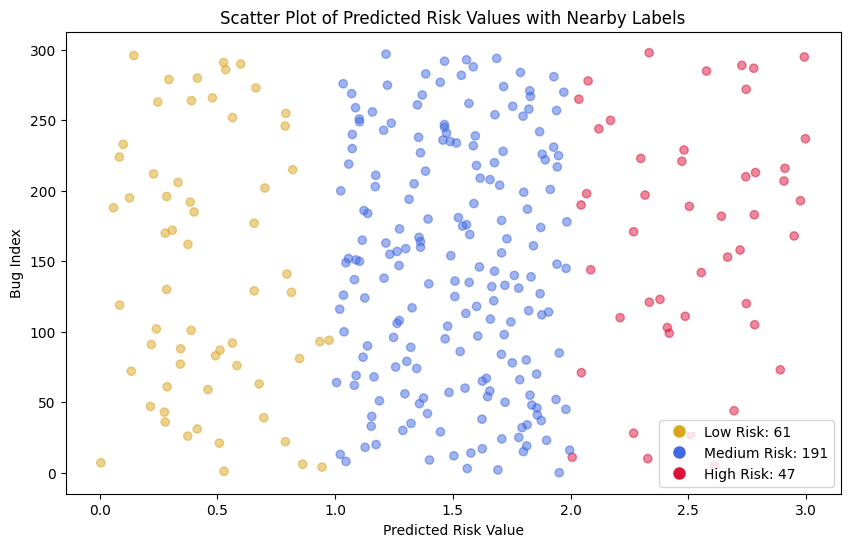

In [ ]:
import matplotlib.pyplot as plt

# Classify the bugs with nearby labels based on ACO-selected features
classified_bugs_aco = classify_bugs(predictions_aco)

# Extract labels and risk values from classified bugs for the first 700 bugs
labels_aco = [label for label, _ in classified_bugs_aco[:700]]
risk_values_aco = [prediction for _, prediction in classified_bugs_aco[:700]]
bug_indices_aco = range(len(labels_aco))

# Sort the bug indices
sorted_bug_indices_aco = sorted(bug_indices_aco)

# Reorder the data based on sorted bug indices
sorted_labels_aco = [labels_aco[i] for i in sorted_bug_indices_aco]
sorted_risk_values_aco = [risk_values_aco[i] for i in sorted_bug_indices_aco]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
colors_aco = {'Low Risk': 'goldenrod', 'Medium Risk': 'royalblue', 'High Risk': 'crimson'}
scatter = plt.scatter(sorted_risk_values_aco, sorted_bug_indices_aco, c=[colors_aco[label] for label in sorted_labels_aco], alpha=0.5)
plt.xlabel('Predicted Risk Value')
plt.ylabel('Bug Index')
plt.title('Scatter Plot of Predicted Risk Values with Nearby Labels')

# Count bugs in each risk category
counts = {label: sorted_labels_aco.count(label) for label in colors_aco.keys()}

# Create legend handles and labels with bug counts
legend_labels = [f'{label}: {count}' for label, count in counts.items()]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_aco[label], markersize=10, label=label) for label in colors_aco.keys()]

plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right')

plt.show()

